# SMS Spam Detection

## Detecting Unwanted Messages

**Table of Content:**

- Introduction
- Problem statement
- Data cleaning
- EDA
- Text preprocessing
- Model training
- Evaluation
- Conclusion

*Introduction*

The objective of this project is to build an efficient SMS Spam Detection model. We want to filter out unwanted messages and ensure that the final user have a smooth and safe text messaging experience.

*Problem statement*

The primary goal is to develop a predictive model that accurately classifies incoming SMS messages as either ham or spam.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
sms = pd.read_csv('spam.csv', encoding='latin1')

In [5]:
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


*Data cleaning*

In [6]:
# Check the data

sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# Drop additional columns

sms.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [8]:
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Rename the columns

sms.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [10]:
sms.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Encode target feature

encoder = LabelEncoder()
sms['target'] = encoder.fit_transform(sms['target'])

In [12]:
sms.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Check for missing values

sms.isnull().sum().sort_values(ascending=False)

target    0
text      0
dtype: int64

In [14]:
# Check for duplicates

sms.duplicated().sum()

403

In [15]:
# Remove duplicates

sms = sms.drop_duplicates(keep='first')

In [16]:
# Shape of dataset

sms.shape

(5169, 2)

*EDA*

In [17]:
# Check the percentages of 'ham' and 'spam'

values = sms['target'].value_counts()
total = values.sum()

pct_0 = (values[0] / total) * 100
pct_1 = (values[1] / total) * 100

print(f"Percentage of ham(0): {pct_0:.2f}%")
print(f"Percentage of spam(1): {pct_1:.2f}%")

Percentage of ham(0): 87.37%
Percentage of spam(1): 12.63%


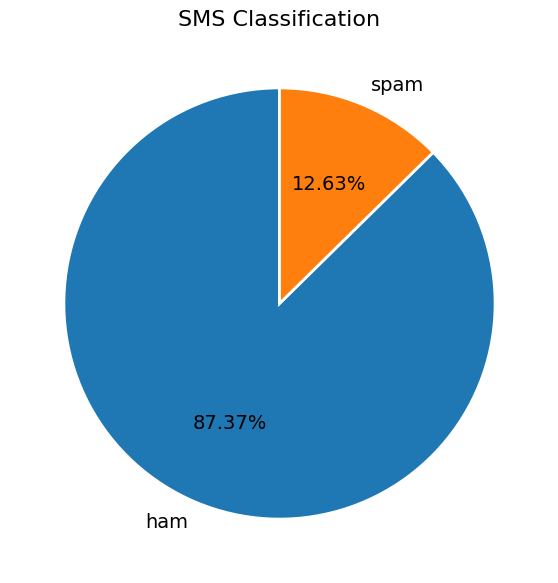

In [18]:
# Plot a pie chart

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
)

# Customize text properties
for text, autotext in zip(texts, autotexts):
  text.set(size=14)
  autotext.set(size=14)

ax.set_title('SMS Classification', fontsize=16)

plt.show()

- The percentage of 'ham' is to high as compare to 'spam' messages percentage. The data is clearly imbalanced.

In [19]:
# Text length & structure analysis

sms['num_char'] = sms['text'].apply(len)
sms['num_words'] = sms['text'].apply(lambda x: len(nltk.word_tokenize(x)))
sms['num_sentence'] = sms['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [20]:
sms[['num_char', 'num_words', 'num_sentence']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_char,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
num_words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0
num_sentence,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0


In [21]:
# Summary statistics for 'ham'

sms[sms['target'] == 0][['num_char', 'num_words', 'num_sentence']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_char,4516.0,70.459256,56.358207,2.0,34.0,52.0,90.0,910.0
num_words,4516.0,17.123782,13.493970,1.0,8.0,13.0,22.0,220.0
num_sentence,4516.0,1.820195,1.383657,1.0,1.0,1.0,2.0,38.0


In [22]:
# Summary statistics for 'spam'

sms[sms['target'] == 1][['num_char', 'num_words', 'num_sentence']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_char,653.0,137.891271,30.137753,13.0,132.0,149.0,157.0,224.0
num_words,653.0,27.667688,7.008418,2.0,25.0,29.0,32.0,46.0
num_sentence,653.0,2.970904,1.488425,1.0,2.0,3.0,4.0,9.0


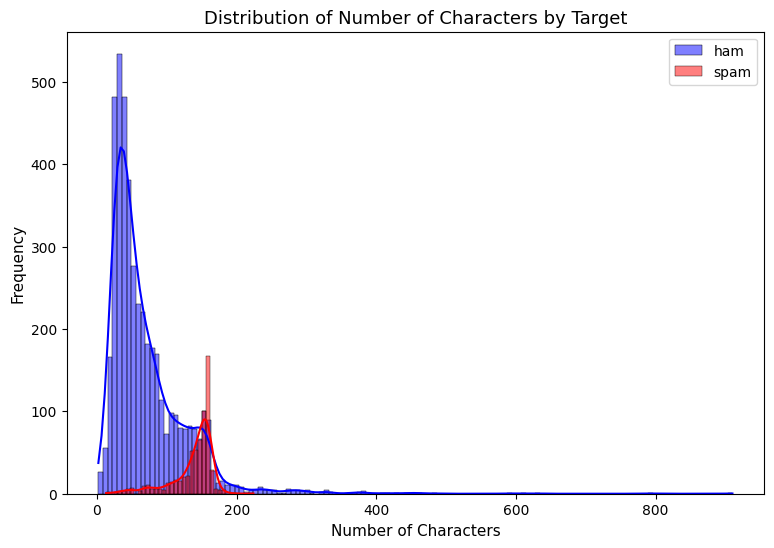

In [23]:
# Char length distribution

plt.figure(figsize=(9, 6))
sns.histplot(sms[sms['target'] == 0]['num_char'], color='blue', label='ham', kde=True) # Histogram for 'ham' in blue
sns.histplot(sms[sms['target'] == 1]['num_char'], color='red', label='spam', kde=True) # Histogram for 'spam' in red
plt.xlabel('Number of Characters', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Number of Characters by Target', fontsize=13)
plt.legend()
plt.show()

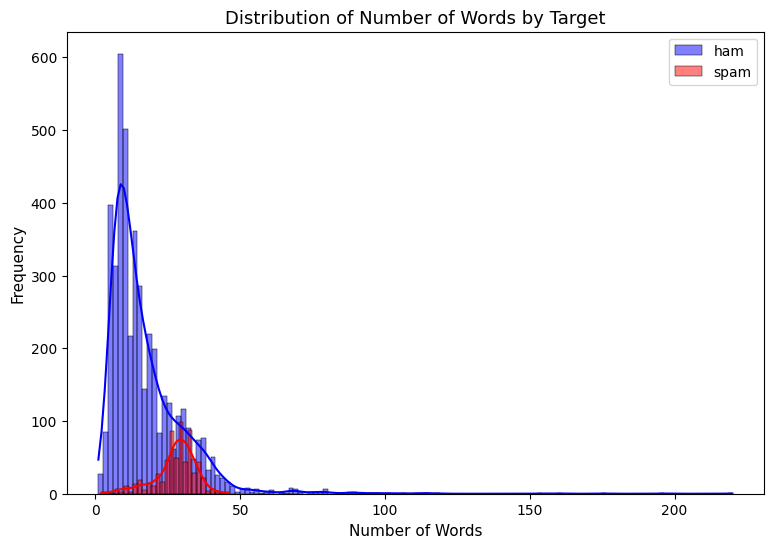

In [24]:
# Word count distribution

plt.figure(figsize=(9, 6))
sns.histplot(sms[sms['target'] == 0]['num_words'], color='blue', label='ham', kde=True) # Histogram for 'ham' in blue
sns.histplot(sms[sms['target'] == 1]['num_words'], color='red', label='spam', kde=True) # Histogram for 'spam' in red
plt.xlabel('Number of Words', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Number of Words by Target', fontsize=13)
plt.legend()
plt.show()

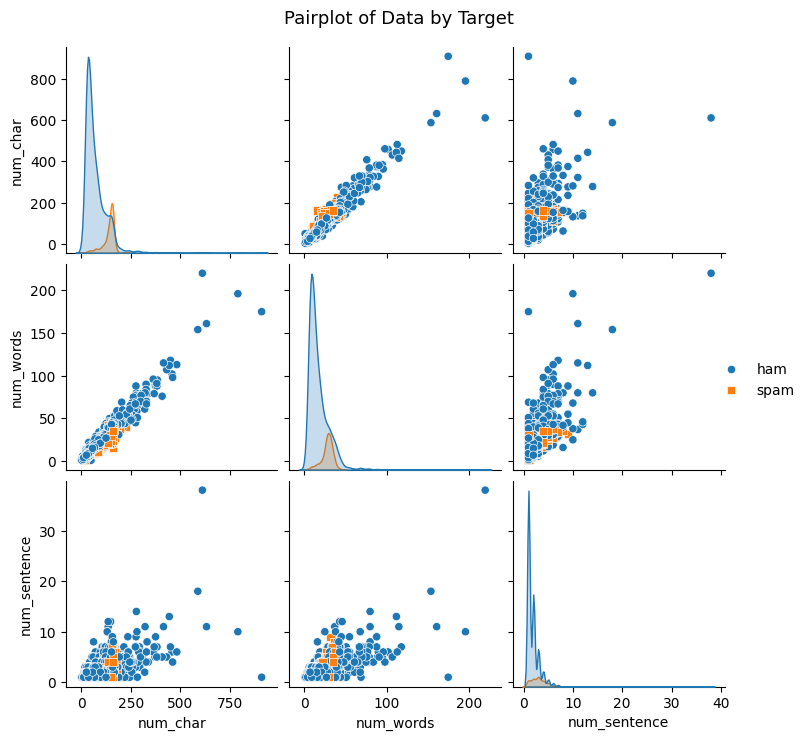

In [25]:
# Pairplot for data visualization

g = sns.pairplot(sms, hue='target', diag_kind='kde', markers=["o", "s"])
g.fig.suptitle("Pairplot of Data by Target", fontsize=13)
plt.subplots_adjust(top=0.93)
g._legend.set_title(' ')

for t, l in zip(g._legend.texts, ["ham", "spam"]):
  t.set_text(l)

plt.show()

In [26]:
# Correlation

sms[['target', 'num_char', 'num_words', 'num_sentence']].corr()

,target,num_char,num_words,num_sentence
target,1.000000,0.384717,0.262912,0.263939
num_char,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentence,0.263939,0.624139,0.679971,1.000000


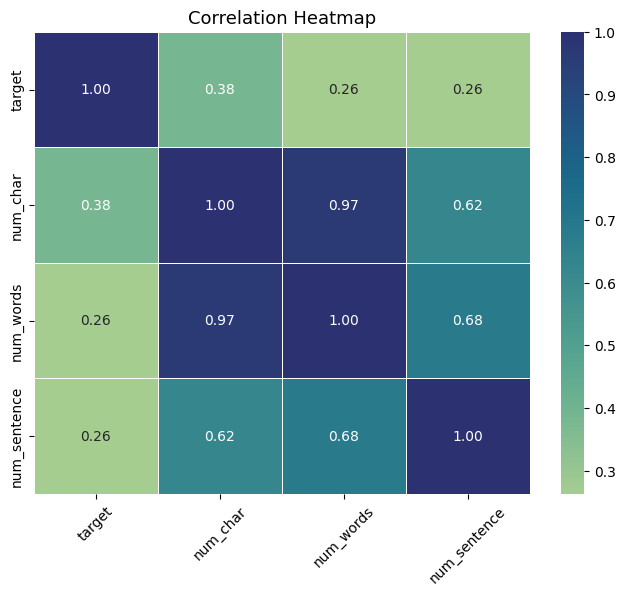

In [27]:
# Heatmap

correlation_matrix = sms[['target', 'num_char', 'num_words', 'num_sentence']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=13)
plt.xticks(rotation=45)
plt.show()

*Text preprocessing*

In [28]:
# Initialize Porter Stemmer

ps = PorterStemmer()

In [29]:
# Create a text preprocessing function

def clean_text(text):
  # Transform the text to lowercase
  text = text.lower()
  # Tokenization using NLTK
  tokens = nltk.word_tokenize(text)
  # Removing special characters
  alphanumeric_tokens = [token for token in tokens if token.isalnum()]
  # Removing stop words and punctuation
  filtered_tokens = [token for token in alphanumeric_tokens if token not in stopwords.words('english') and token not in string.punctuation]
  # Stemming using Porter Stemmer
  stemmed_tokens = [ps.stem(token) for token in filtered_tokens]
  # Join the processed tokens back into a single string
  processed_text = " ".join(stemmed_tokens)

  return processed_text

In [30]:
# Create a new column called 'processed_text'

sms['processed_text'] = sms['text'].apply(clean_text)

In [31]:
sms.head()

,target,text,num_char,num_words,num_sentence,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


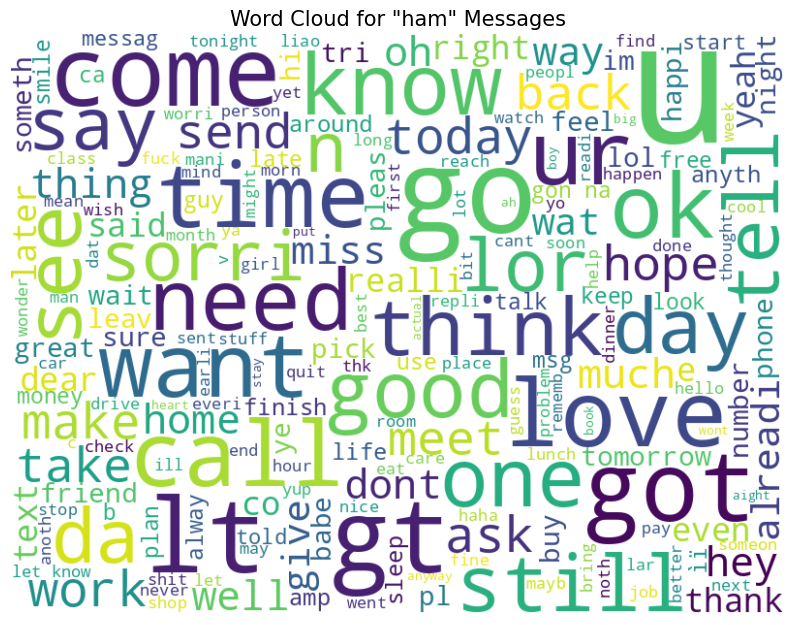

In [32]:
# Word cloud for 'ham'

wc = WordCloud(width=800, height=600, max_words=200, max_font_size=175,
               background_color='white', colormap='viridis', random_state=42)

ham_wc = wc.generate(sms[sms['target'] == 0]['processed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 8))
plt.imshow(ham_wc, interpolation='bilinear')
plt.title('Word Cloud for "ham" Messages', fontsize=15)
plt.axis('off')
plt.show()

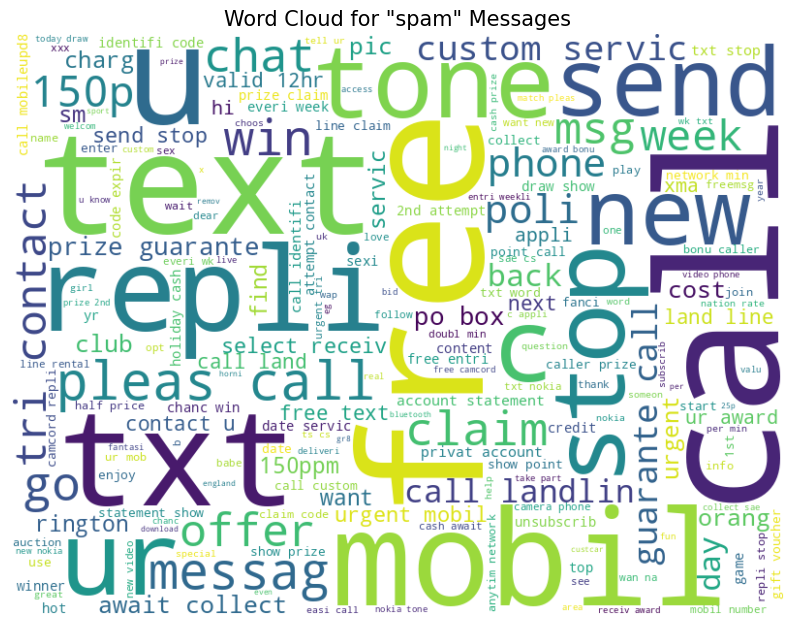

In [33]:
# Word cloud for 'spam'

spam_wc = wc.generate(sms[sms['target'] == 1]['processed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 8))
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Word Cloud for "spam" Messages', fontsize=15)
plt.axis('off')
plt.show()

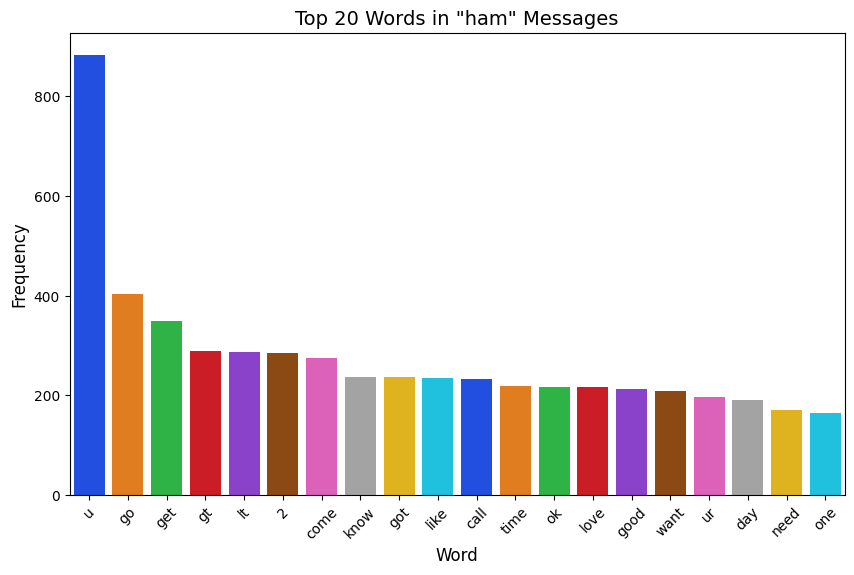

In [34]:
# Find top 20 words of 'ham' messages

ham_words = sms[sms['target'] == 0]['processed_text'].str.split(expand=True).stack().value_counts().head(20)

top_ham_words_df = pd.DataFrame({'Word': ham_words.index, 'Frequency': ham_words.values})

plt.figure(figsize=(10, 6))
sns.barplot(data=top_ham_words_df, x='Word', y='Frequency', palette='bright')
plt.title('Top 20 Words in "ham" Messages', fontsize=14)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

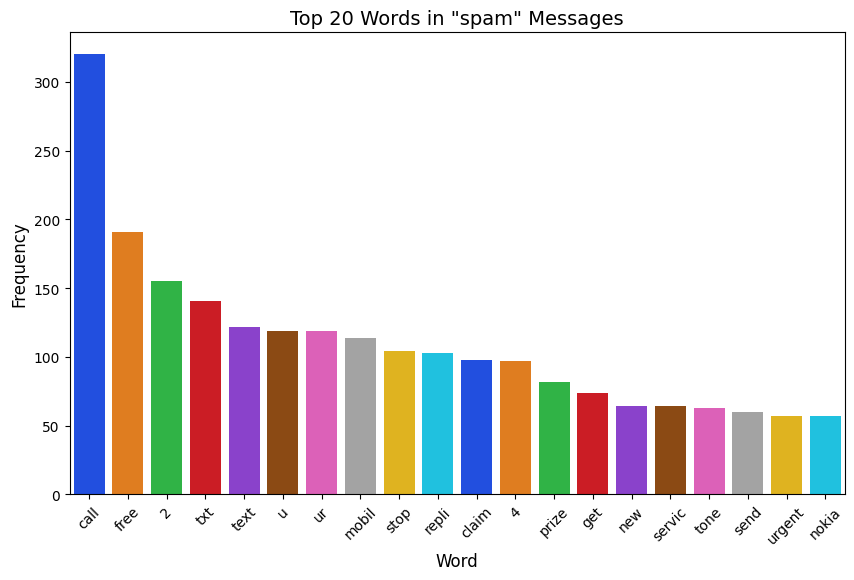

In [35]:
# Find top 20 words of 'spam' messages

spam_words = sms[sms['target'] == 1]['processed_text'].str.split(expand=True).stack().value_counts().head(20)

top_spam_words_df = pd.DataFrame({'Word': spam_words.index, 'Frequency': spam_words.values})

plt.figure(figsize=(10, 6))
sns.barplot(data=top_spam_words_df, x='Word', y='Frequency', palette='bright')
plt.title('Top 20 Words in "spam" Messages', fontsize=14)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

*Model training*

In [36]:
# Initializing TfidfVectorizer

tfid = TfidfVectorizer(max_features=3000)

In [37]:
# Dependent and independent variables

X = tfid.fit_transform(sms['processed_text']).toarray()
y = sms['target'].values

In [38]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Print the shapes

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (4135, 3000)
Shape of X_test:  (1034, 3000)
Shape of y_train:  (4135,)
Shape of y_test:  (1034,)


In [40]:
# Initialize the models

lrc = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=42)

In [41]:
# Create a dictionary of the models

clfs = {
    'LR': lrc,
    'DT': dtc,
    'NB': mnb,
    'RF': rfc,
    'GBDT': gbdt
}

In [42]:
# Train the models

def train_classifier(clfs, X_train, y_train, X_test, y_test):
  clfs.fit(X_train, y_train)
  y_pred = clfs.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  return accuracy, precision

*Evaluation*

In [43]:
# Evaluate the models

accuracy_scores = []
precision_scores = []

for name, clfs in clfs.items():
  current_accuracy, current_precision = train_classifier(clfs, X_train, y_train, X_test, y_test)

  print()
  print("For: ", name)
  print("Accuracy: ", current_accuracy)
  print("Precision: ", current_precision)

  accuracy_scores.append(current_accuracy)
  precision_scores.append(current_precision)


For:  LR
Accuracy:  0.9468085106382979
Precision:  0.8688524590163934

For:  DT
Accuracy:  0.9342359767891683
Precision:  0.8347826086956521

For:  NB
Accuracy:  0.9729206963249516
Precision:  0.9915966386554622

For:  RF
Accuracy:  0.9700193423597679
Precision:  0.9830508474576272

For:  GBDT
Accuracy:  0.9468085106382979
Precision:  0.96875


*Conclusion*

Based on the analysis and evaluation of the **SMS Spam Detection** project, we can draw several conclusions and provide recommendations for further improvement.

**Model Performance Evaluation:**

- The project aimed to build an efficient SMS detection model to accurately classify messages as either ham or spam.
- We evaluated multiple models, including Logistic Regression, Decision Trees, Multinomial Naive Bayes, Random Forest, and Gradient Boosting.
-Among these models, Multinomial Naive Bayes achieved the highest accuracy of 97.29% and precision of 99.16%, indicating its effectiveness in classifying both ham and spam messages.

**Further Recommendations:**

- Fine-Tuning: Fine-tuning hyperparameters of the models, especially for Decision Trees and Gradient Boosting, could potentially improve their performance. Techniques like grid search or random search could be employed to find the optimal hyperparameters.
- Feature Engineering: Exploring additional features or feature combinations derived from the text data could enhance the model's predictive power. Techniques like n-grams or word embeddings might capture more nuanced patterns in the text.
- Imbalanced Data Handling: Since the dataset is highly imbalanced, employing techniques like oversampling, undersampling, or using class weights during model training could mitigate the impact of class imbalance and improve model generalization.

**Final Thoughts:**

- In conclusion, the project successfully developed and evaluated several models for SMS spam detection, with Multinomial Naive Bayes emerging as the top-performing model based on accuracy and precision metrics.
- The project contributes to enhancing user experience by filtering out unwanted messages and ensuring a smooth and safe communication environment.
- Further refinement through fine-tuning, and feature engineering could potentially elevate the model's performance and robustness.

Overall, the project lays a solid foundation for effective SMS spam detection, and continued exploration and refinement of the models could lead to even better results and user experiences in the future.